# Proyecto : #

### **Refinamiento de los mejores modelos de clasificación encontrados para predecir especies de pingüino** ###

### Fase 1: Carga de los datos y preprocesamiento ###

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download parulpandey/palmer-archipelago-antarctica-penguin-data
! unzip palmer-archipelago-antarctica-penguin-data.zip

mkdir: /Users/Facundo/.kaggle: File exists
cp: /content/drive/MyDrive/kaggle.json: No such file or directory
chmod: /Users/Facundo/.kaggle/kaggle.json: No such file or directory
Traceback (most recent call last):
  File "/opt/anaconda3/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/anaconda3/lib/python3.9/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/anaconda3/lib/python3.9/site-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /Users/Facundo/.kaggle. Or use the environment method.
unzip:  cannot find or open palmer-archipelago-antarctica-penguin-data.zip, palmer-archipelago-antarctica-penguin-data.zip.zip or palmer-archipelago-antarctica-penguin-data.zip.ZIP.


In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# importamos la librerías necesarias para la carga e información de nuestro dataset

In [3]:
import pandas as pd
penguins = pd.read_csv('penguins_size.csv').dropna()
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [4]:
penguins.sex.replace({'.':'FEMALE'},inplace=True)
# Reemplazamos el valor "." por 'FEMALE' para dejar esta variable todavía mas equilibrada

In [5]:
penguins.sex.value_counts()
# Realizamos lo mismo con la variable sex

MALE      168
FEMALE    166
Name: sex, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

X = penguins.drop("species", axis=1)

y = penguins.species.astype("category").cat.codes
# Usar esta instrucción cuando se requieran etiquetas de clase codificadas numéricamente, p.ej. si vamos 
# a visualizar la curva ROC y calcular AUC o si vamos a hacer búsqueda de hiperparámetros para optimizar
# modelos.


X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=.2, random_state=42)

In [7]:
X_train_num = X_train.drop(["island", "sex"], axis=1) 
# Obtener una versión solo con atributos numéricos para rellenar valores perdidos

from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy="median") 
# Rellenar valores perdidos de atributos numéricos con la mediana de éste

X_train_num_array = num_imputer.fit_transform(X_train_num)
X_train_num = pd.DataFrame(X_train_num_array, columns=X_train_num.columns, index=X_train_num.index) # Al aplicar una imputación se pierde la estructura de DataFrame, pero se puede volver a crear
X_train_num.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
230,40.9,13.7,214.0,4650.0
84,37.3,17.8,191.0,3350.0
303,50.0,15.9,224.0,5350.0
22,35.9,19.2,189.0,3800.0
29,40.5,18.9,180.0,3950.0


*Utilizamos **OneHotEncoder** para transformar el valor categórico de *'island'**

In [8]:
from sklearn.preprocessing import OneHotEncoder

# Inicializamos OneHotEncoder
encoder = OneHotEncoder()

encoder.fit(X_train[["island"]])
X_train_encoded = encoder.transform(X_train[["island"]]).toarray()

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names(X_train[["island"]].columns))

X_train_encoded_df.head()

,island_Biscoe,island_Dream,island_Torgersen
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


Aquí se comparan los tres nuevos atributos con el atributo categórico original del que provienen.

Una vez hemos realizado el tratamiento de **atributos numéricos** y **atributo categórico** de forma separada, volver a unificarlos en una nueva versión de los datos de entrenamiento.

**CUIDADO**: Nótese que una de las transformaciones previas, la de obtener nuevos atributos mediante *OneHotEncoder* ha originado nuevos índices asociados a las instancias. Aunque estos índices no cuentan como datos relevantes al posterior algoritmo de ML, re-unificar múltiples subconjuntos de atributos con diferentes índices es una fuente de problemas.

La solución más seguro es resetear los índices de ambas partes a fusionar, como se muestra a continuación:

In [9]:
X_train_num.reset_index(drop=True, inplace=True) # Resetear índices de las instancias para asegurar coherencia al fusionar los datos

X_train_encoded_df.reset_index(drop=True, inplace=True) # Resetear índices de las instancias para asegurar coherencia al fusionar los datos

X_train_prepared = pd.concat([X_train_num, X_train_encoded_df], axis=1) # Se fusionan todos los atributos necesarios

X_train_prepared

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen
0,40.9,13.7,214.0,4650.0,1.0,0.0,0.0
1,37.3,17.8,191.0,3350.0,0.0,1.0,0.0
2,50.0,15.9,224.0,5350.0,1.0,0.0,0.0
3,35.9,19.2,189.0,3800.0,1.0,0.0,0.0
4,40.5,18.9,180.0,3950.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
262,50.9,19.1,196.0,3550.0,0.0,1.0,0.0
263,37.2,19.4,184.0,3900.0,0.0,0.0,1.0
264,39.7,17.7,193.0,3200.0,1.0,0.0,0.0
265,45.5,15.0,220.0,5000.0,1.0,0.0,0.0


Para realizar predicciones sobre los **datos de test** necesitaremos aplicar la misma secuencia de transformaciones que originalmente aplicamos sobre los datos de entrenamiento.

En los datos de **test** usamos el mismo transformador *OneHotEncoder* definido previamente para los datos de entrenamiento, invocando directamente el método *transform()*: no se debe llamar el método *fit()* de nuevo, ya que el modo de ***transformar los datos*** debe ser ***según lo aprendido de los datos de entrenamiento***.

In [10]:
X_test_encoded = encoder.transform(X_test[["island"]]).toarray() # Aplicar transformador OneHotEncoder

X_test_encoded_df = pd.DataFrame(X_test_encoded,
                                 columns=encoder.get_feature_names(X_test[["island"]].columns))

X_test_num = X_test.drop(["island","sex"], axis=1)

X_test_num_array = num_imputer.transform(X_test_num) # Aplicar transformador para imputar valores numéricos perdidos
X_test_num = pd.DataFrame(X_test_num_array, columns=X_test_num.columns, index=X_test_num.index) 
# Al aplicar una imputación se pierde la estructura de DataFrame, pero se puede volver a crear

# Resetear indices en atributos numéricos y en los binarios (derivados del atributo categórico), antes de fusionarlos.
X_test_num.reset_index(drop=True, inplace=True)
X_test_encoded_df.reset_index(drop=True, inplace=True)

X_test_prepared = pd.concat([X_test_num,X_test_encoded_df], axis=1) # Se fusionan todos los atributos necesarios
X_test_prepared

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen
0,39.5,16.7,178.0,3250.0,0.0,1.0,0.0
1,46.9,14.6,222.0,4875.0,1.0,0.0,0.0
2,42.1,19.1,195.0,4000.0,0.0,0.0,1.0
3,49.8,17.3,198.0,3675.0,0.0,1.0,0.0
4,41.1,18.2,192.0,4050.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
62,43.5,14.2,220.0,4700.0,1.0,0.0,0.0
63,36.7,19.3,193.0,3450.0,0.0,0.0,1.0
64,35.1,19.4,193.0,4200.0,0.0,0.0,1.0
65,51.1,16.5,225.0,5250.0,1.0,0.0,0.0


# Sprint 1 #

1. Entrenar y evaluar sobre datos de test un clasificador basado en regresión softmax.

2. Entrenar y evaluar sobre datos de test un clasificador de los estudiados en el anterior módulo, por ejemplo SVM, a elección del alumno.

3. Analizar, discutir y comparar los resultados.

### Punto 1: Ajuste del algoritmo de Regresión SoftMax ###

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Preparación del algoritmo SoftMax
softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=10000)
softmax_reg.fit(X_train_prepared, y_train)

LogisticRegression(max_iter=10000, multi_class='multinomial')

In [12]:
y_pred_tr = softmax_reg.predict(X_train_prepared)
resultado_sm_tr = accuracy_score(y_train, y_pred_tr)
print (resultado_sm_tr)
# Evaluamos la precisión del modelo en entrenamiento

0.9962546816479401


In [13]:
y_pred = softmax_reg.predict(X_test_prepared)
resultado_sm_te = accuracy_score(y_test, y_pred)
print (resultado_sm_te)
# Evaluamos la precisión del modelo en datos de test

0.9850746268656716


### Punto 2: Ajuste del algoritmo de Support Vector Machine. ###

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC 
# Cargamos la librería, esta vez utilizamos un Pipeline y el modelo SVM previo escalado de los datos

In [15]:
svm_classifier = Pipeline([
                           ("scaler", StandardScaler()),
                           ("linear_svc", LinearSVC(C=1, loss="hinge", max_iter=10000)),
])
# Definir una secuencia de acciones (pipeline) sencilla, consistente en entrenar un modelo SVM 
# precedido de un escalado de los atributos.

svm_classifier.fit(X_train_prepared, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', max_iter=10000))])

In [16]:
y_pred_tr_svm = svm_classifier.predict(X_train_prepared)
resultado_svm_tr = accuracy_score(y_train, y_pred_tr_svm)
print (resultado_svm_tr)
# Evaluamos la precisión del modelo en entrenamiento

0.9962546816479401


In [17]:
y_pred_te_svm = svm_classifier.predict(X_test_prepared)
resultado_svm_te = accuracy_score(y_test, y_pred_te_svm)
print (resultado_svm_te)
# Evaluamos la precisión del modelo en test

1.0


### Punto 3: Analizar los resultados. ###

In [18]:
print (resultado_sm_te)
print (resultado_svm_te)

0.9850746268656716
1.0


*Podemos observar que ambos modelos clasifican correctamente nuestras instancias, con un muy buen resultado para el SVM y la Regresion Softmax. A continuación realizó un Grid Search del algoritmo SVM para ver si los hiperparametros son los mejores que podemos obtener para este resultado.*

* Grid Search de SVM

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
 
# Hiperparametros
param_grid = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [0.1,1,10]},
    {"kernel": ["linear"], "C": [0.1,1,10]},
    {"kernel": ["poly"], "C": [0.1,1,10], "degree": [2,3]},
]
 
grid = GridSearchCV(
        estimator  = SVC(),
        param_grid = param_grid, 
      )
# Se asigna el resultado a _ para que no se imprima por pantalla
grid.fit(X = X_train_prepared, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(10)

,param_C,param_gamma,param_kernel,param_degree,mean_test_score,std_test_score
6,0.1,NaN,linear,NaN,0.988679,0.015094
8,10,NaN,linear,NaN,0.981272,0.016721
7,1,NaN,linear,NaN,0.981202,0.020669
5,10,0.0001,rbf,NaN,0.793641,0.047422
4,10,0.001,rbf,NaN,0.771628,0.023905
2,1,0.001,rbf,NaN,0.726205,0.056778
10,0.1,NaN,poly,3,0.722502,0.061415
11,1,NaN,poly,2,0.722502,0.046962
12,1,NaN,poly,3,0.722502,0.046962
9,0.1,NaN,poly,2,0.715094,0.057574


*Luego del Grid Search observamos que el mejor modelo de SVM es con el hiperparametro C = 0.1 y un kernel linear*

In [20]:
svm_classifier_gs = Pipeline([
                           ("scaler", StandardScaler()),
                           ("linear_svc", LinearSVC(C=0.1, loss="hinge", max_iter=10000)),
])
# Definir una secuencia de acciones (pipeline) sencilla, consistente en entrenar un modelo SVM 
# precedido de un escalado de los atributos.

svm_classifier_gs.fit(X_train_prepared, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=0.1, loss='hinge', max_iter=10000))])

In [21]:
y_pred_te_svm = svm_classifier_gs.predict(X_test_prepared)
resultado_svm_te_gs = accuracy_score(y_test, y_pred_te_svm)
print (resultado_svm_te_gs)
# Evaluamos la precisión del modelo en test

1.0


## **Que sucede si no preprocesamos los datos ?** ##

In [22]:
import pandas as pd
penguinsNO = pd.read_csv('penguins_size.csv').dropna()
penguinsNO.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [23]:
from sklearn.model_selection import train_test_split

# Separar atributos predictores y atributo de clase
# Para los atributos predictores nos quedamos solamente con los numéricos y excluimos los categóricos
X = penguinsNO.select_dtypes(exclude=['object'])
y = penguinsNO.species

# Crear conjuntos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC 
# Cargamos la librería, esta vez utilizamos un Pipeline y el modelo SVM previo escalado de los datos

In [25]:
svm_classifier = Pipeline([
                           ("scaler", StandardScaler()),
                           ("linear_svc", LinearSVC(C=1, loss="hinge", max_iter=10000)),
])
# Definir una secuencia de acciones (pipeline) sencilla, consistente en entrenar un modelo SVM 
# precedido de un escalado de los atributos.

svm_classifier.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', max_iter=10000))])

In [26]:
y_pred_tr_svm = svm_classifier.predict(X_train)
resultado_svm_tr = accuracy_score(y_train, y_pred_tr_svm)
print (resultado_svm_tr)
# Evaluamos la precisión del modelo en entrenamiento

0.9871244635193133


In [27]:
y_pred_te_svm = svm_classifier.predict(X_test)
resultado_svm_te = accuracy_score(y_test, y_pred_te_svm)
print (resultado_svm_te)
# Evaluamos la precisión del modelo en test

0.9801980198019802


In [28]:
SVM_procesador = print (resultado_svm_te_gs)
SVM_no_procesado = print (resultado_svm_te)

1.0
0.9801980198019802


**Sin preprocesar nuestros datos, de obtener una precisión del 100 % en nuestro clasificador de SVM, caemos a un 98 %. Si bien ambos resultados son óptimos, sirve la diferencia para destacar la importancia del preprocesamiento de los datos**

### PARTE OPCIONAL: Reformular el problema de clasificación de pingüinos como una clasificación binaria (clase positiva vs clase negativa) y entrenar y evaluar un modelo de regresión logística. ###

In [29]:
X = penguins.drop("species", axis=1)

y = penguins.species.astype("category").cat.codes == 1


X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=.2, random_state=42)

In [30]:
X_train_num = X_train.drop(["island", "sex"], axis=1) # Obtener una versión solo con atributos numéricos para rellenar valores perdidos

from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy="median") # Rellenar valores perdidos de atributos numéricos con la mediana de éste

X_train_num_array = num_imputer.fit_transform(X_train_num)
X_train_num = pd.DataFrame(X_train_num_array, columns=X_train_num.columns, index=X_train_num.index) # Al aplicar una imputación se pierde la estructura de DataFrame, pero se puede volver a crear

In [31]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder()

encoder.fit(X_train[["island"]])
X_train_encoded = encoder.transform(X_train[["island"]]).toarray()

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names(X_train[["island"]].columns))

In [32]:
X_train_num.reset_index(drop=True, inplace=True) # Resetear índices de las instancias para asegurar coherencia al fusionar los datos

X_train_encoded_df.reset_index(drop=True, inplace=True) # Resetear índices de las instancias para asegurar coherencia al fusionar los datos

X_train_prepared = pd.concat([X_train_num, X_train_encoded_df], axis=1) # Se fusionan todos los atributos necesarios

In [33]:
X_test_encoded = encoder.transform(X_test[["island"]]).toarray() # Aplicar transformador OneHotEncoder

X_test_encoded_df = pd.DataFrame(X_test_encoded,
                                 columns=encoder.get_feature_names(X_test[["island"]].columns))

X_test_num = X_test.drop(["island","sex"], axis=1)

X_test_num_array = num_imputer.transform(X_test_num) # Aplicar transformador para imputar valores numéricos perdidos
X_test_num = pd.DataFrame(X_test_num_array, columns=X_test_num.columns, index=X_test_num.index) 
# Al aplicar una imputación se pierde la estructura de DataFrame, pero se puede volver a crear

# Resetear indices en atributos numéricos y en los binarios (derivados del atributo categórico), antes de fusionarlos.
X_test_num.reset_index(drop=True, inplace=True)
X_test_encoded_df.reset_index(drop=True, inplace=True)

X_test_prepared = pd.concat([X_test_num,X_test_encoded_df], axis=1) # Se fusionan todos los atributos necesarios

In [34]:
log_reg = LogisticRegression(max_iter=1000) # Usamos este hiperparámetro para asegurar convergencia.
log_reg.fit(X_train_prepared, y_train)

test_predictions = log_reg.predict(X_test_prepared)

score = log_reg.score(X_test_prepared, y_test) # Calculamos el proder predictivo del modelo sobre el conjunto de test como el % de aciertos.
score

0.9701492537313433

*Utilizando una clasificación binaria, donde nuestro resultado sea clasificar si corresponden o no a una clase de pinguino, nuestro clasificador de regresión logística tiene un accuracy de 0.97, lo cual es un buen resultado también, pero observamos como el rendimiento del clasificador baja cuando pasamos de una clasificación binaria a una clasificación multiclase.*

# Sprint 2 #

1. Entrenar 4 modelos de árbol de decisión: uno de ellos sin restricciones algunas (sin especificar hiperparámetros), y los otros tres bajo diferentes configuraciones de hiperparámetros que apliquen regularización sobre el crecimiento y forma del árbol durante su entrenamiento.

2. Identificar y justificar la elección del árbol con mejor poder predictivo.

3. Comparar los resultados con los de los clasificadores entrenados en tu sprint anterior, y determinar el mejor clasificador encontrado hasta ahora.

In [35]:
from sklearn import tree
import matplotlib.pyplot as plt

### Punto 1: Entrenar 4 arboles de decisión. ###

In [36]:
X = penguins.drop("species", axis=1)

y = penguins.species.astype("category").cat.codes 


X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=.3, random_state=42)

In [37]:
X_train_num = X_train.drop(["island", "sex"], axis=1) # Obtener una versión solo con atributos numéricos para rellenar valores perdidos

from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy="median") # Rellenar valores perdidos de atributos numéricos con la mediana de éste

X_train_num_array = num_imputer.fit_transform(X_train_num)
X_train_num = pd.DataFrame(X_train_num_array, columns=X_train_num.columns, index=X_train_num.index) # Al aplicar una imputación se pierde la estructura de DataFrame, pero se puede volver a crear

In [38]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder()

encoder.fit(X_train[["island"]])
X_train_encoded = encoder.transform(X_train[["island"]]).toarray()

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names(X_train[["island"]].columns))

In [39]:
X_train_num.reset_index(drop=True, inplace=True) # Resetear índices de las instancias para asegurar coherencia al fusionar los datos

X_train_encoded_df.reset_index(drop=True, inplace=True) # Resetear índices de las instancias para asegurar coherencia al fusionar los datos

X_train_prepared = pd.concat([X_train_num, X_train_encoded_df], axis=1) # Se fusionan todos los atributos necesarios

In [40]:
X_test_encoded = encoder.transform(X_test[["island"]]).toarray() # Aplicar transformador OneHotEncoder

X_test_encoded_df = pd.DataFrame(X_test_encoded,
                                 columns=encoder.get_feature_names(X_test[["island"]].columns))

X_test_num = X_test.drop(["island","sex"], axis=1)

X_test_num_array = num_imputer.transform(X_test_num) # Aplicar transformador para imputar valores numéricos perdidos
X_test_num = pd.DataFrame(X_test_num_array, columns=X_test_num.columns, index=X_test_num.index) 
# Al aplicar una imputación se pierde la estructura de DataFrame, pero se puede volver a crear

# Resetear indices en atributos numéricos y en los binarios (derivados del atributo categórico), antes de fusionarlos.
X_test_num.reset_index(drop=True, inplace=True)
X_test_encoded_df.reset_index(drop=True, inplace=True)

X_test_prepared = pd.concat([X_test_num,X_test_encoded_df], axis=1) # Se fusionan todos los atributos necesarios

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Primer árbol sin restricciones
tree_clf1 = DecisionTreeClassifier(random_state=42)

tree_clf1.fit(X_train_prepared, y_train)
y_pred1_tr = tree_clf1.predict(X_train_prepared)
print ('accuracy score para train:',accuracy_score(y_pred1_tr, y_train))
y_pred1_te = tree_clf1.predict(X_test_prepared)
print ('accuracy score para test:',accuracy_score(y_pred1_te, y_test))

accuracy score para train: 1.0
accuracy score para test: 0.9801980198019802


In [42]:
print(confusion_matrix(y_test, y_pred1_te))

[[48  1  0]
 [ 1 17  0]
 [ 0  0 34]]


In [43]:
print(classification_report(y_test, y_pred1_te))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        49
           1       0.94      0.94      0.94        18
           2       1.00      1.00      1.00        34

    accuracy                           0.98       101
   macro avg       0.97      0.97      0.97       101
weighted avg       0.98      0.98      0.98       101



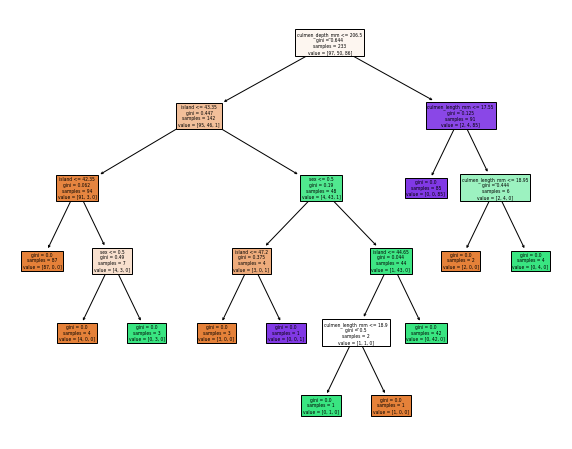

In [44]:
plt.figure(figsize = (10,8))
tree.plot_tree(tree_clf1, filled = True, feature_names= X.columns)
plt.show()

In [45]:
# Segundo árbol con max_depth = 5
tree_clf2 = DecisionTreeClassifier(max_depth=5, random_state=42)

tree_clf2.fit(X_train_prepared, y_train)
y_pred2_tr = tree_clf2.predict(X_train_prepared)
print ('accuracy score para train:',accuracy_score(y_pred2_tr, y_train))
y_pred2_te= tree_clf2.predict(X_test_prepared)
print ('accuracy score para test:',accuracy_score(y_pred2_te, y_test))

accuracy score para train: 1.0
accuracy score para test: 0.9801980198019802


In [46]:
print(confusion_matrix(y_test, y_pred2_te))

[[48  1  0]
 [ 1 17  0]
 [ 0  0 34]]


In [47]:
print(classification_report(y_test, y_pred2_te))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        49
           1       0.94      0.94      0.94        18
           2       1.00      1.00      1.00        34

    accuracy                           0.98       101
   macro avg       0.97      0.97      0.97       101
weighted avg       0.98      0.98      0.98       101



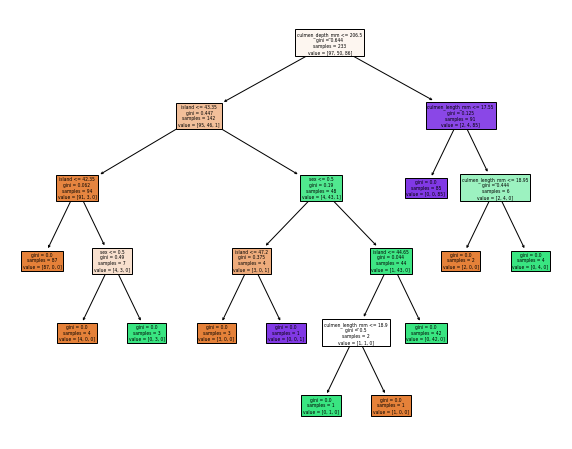

In [48]:
plt.figure(figsize = (10,8))
tree.plot_tree(tree_clf2, filled = True, feature_names= X.columns)
plt.show()

In [49]:
# Tercer árbol con min_samples_split=10
tree_clf3 = DecisionTreeClassifier(min_samples_split=10, random_state=42)

tree_clf3.fit(X_train_prepared, y_train)
y_pred3_tr = tree_clf3.predict(X_train_prepared)
print ('accuracy score para train:',accuracy_score(y_pred3_tr, y_train))
y_pred3_te= tree_clf3.predict(X_test_prepared)
print ('accuracy score para test:',accuracy_score(y_pred3_te, y_test))

accuracy score para train: 0.9699570815450643
accuracy score para test: 0.9801980198019802


In [50]:
print(confusion_matrix(y_test, y_pred3_te))

[[49  0  0]
 [ 2 16  0]
 [ 0  0 34]]


In [51]:
print(classification_report(y_test, y_pred3_te))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        49
           1       1.00      0.89      0.94        18
           2       1.00      1.00      1.00        34

    accuracy                           0.98       101
   macro avg       0.99      0.96      0.97       101
weighted avg       0.98      0.98      0.98       101



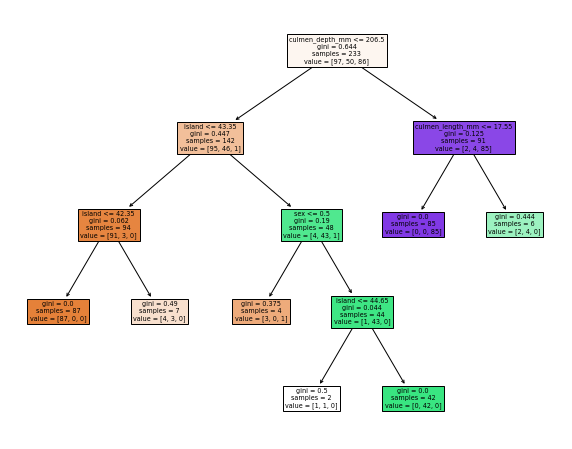

In [52]:
plt.figure(figsize = (10,8))
tree.plot_tree(tree_clf3, filled = True, feature_names= X.columns)
plt.show()

In [53]:
# Cuarto árbol combinando 3 hiperparametros
tree_clf4 = DecisionTreeClassifier(max_depth =5, min_samples_split=10, max_leaf_nodes = 5, random_state=42)

tree_clf4.fit(X_train_prepared, y_train)
y_pred4_tr = tree_clf4.predict(X_train_prepared)
print ('accuracy score para train:',accuracy_score(y_pred4_tr, y_train))
y_pred4_te= tree_clf4.predict(X_test_prepared)
print ('accuracy score para test:',accuracy_score(y_pred4_te, y_test))

accuracy score para train: 0.9699570815450643
accuracy score para test: 0.9801980198019802


In [54]:
print(confusion_matrix(y_test, y_pred4_te))

[[49  0  0]
 [ 2 16  0]
 [ 0  0 34]]


In [55]:
print(classification_report(y_test, y_pred4_te))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        49
           1       1.00      0.89      0.94        18
           2       1.00      1.00      1.00        34

    accuracy                           0.98       101
   macro avg       0.99      0.96      0.97       101
weighted avg       0.98      0.98      0.98       101



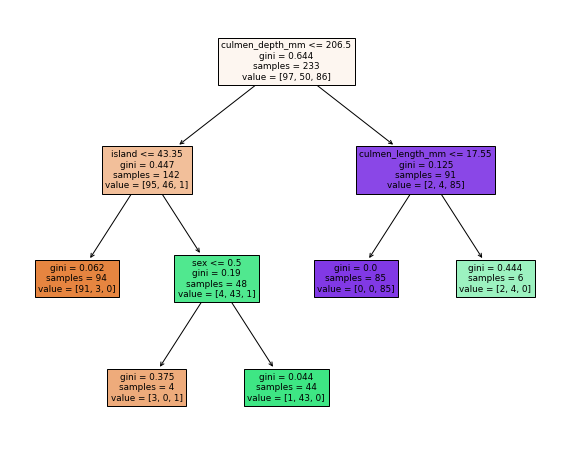

In [56]:
plt.figure(figsize = (10,8))
tree.plot_tree(tree_clf4, filled = True, feature_names= X.columns)
plt.show()

### Punto 2: Identificar y justificar la elección del árbol con mejor poder predictivo. ###

*Por lo anteriormente expuesto, creo que el mejor árbol es el nro 3 **(tree_clf3 = DecisionTreeClassifier(min_samples_split=10, random_state=42)** con un accuracy similar entre train y test nos demuestra que no existe overfitting en nuestro modelo, y que clasifica al 100 % tanto la clase 1 como la clase 3, con dos errores en la clase 1 (recall).*

In [57]:
print ('accuracy score para train:',accuracy_score(y_pred3_tr, y_train))
print ('accuracy score para test:',accuracy_score(y_pred3_te, y_test))

accuracy score para train: 0.9699570815450643
accuracy score para test: 0.9801980198019802


In [58]:
print(confusion_matrix(y_test, y_pred3_te))

[[49  0  0]
 [ 2 16  0]
 [ 0  0 34]]


In [59]:
print(classification_report(y_test, y_pred3_te))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        49
           1       1.00      0.89      0.94        18
           2       1.00      1.00      1.00        34

    accuracy                           0.98       101
   macro avg       0.99      0.96      0.97       101
weighted avg       0.98      0.98      0.98       101



### Punto 3: Comparar los resultados con los de los clasificadores entrenados en tu sprint anterior, y determinar el mejor clasificador encontrado hasta ahora. ###

*De los anteriores modelos, comparando los resultados vemos que el mejor hasta ahora es el Regresor SoftMax **softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=10000)** con un resultado superior al de nuestro mejor árbol de decisión y al SVM.*

In [60]:
print ('accuracy score para Regresión SoftMax:',resultado_sm_te)
print ('accuracy score para Arbol de Decisión:',accuracy_score(y_pred3_te, y_test))
print ('accuracy score para Support Vector Machine:',resultado_svm_te)

accuracy score para Regresión SoftMax: 0.9850746268656716
accuracy score para Arbol de Decisión: 0.9801980198019802
accuracy score para Support Vector Machine: 0.9801980198019802


**Entre todos los clasificador hasta el momento entrenados, utilizando todas las variantes númericas y categóricas, nuestro mejor clasificador es el Support Vector Machine con grid search mostrando los mejores parámetros para utilizarlo.**

# Sprint 3 #

*Aplicar al menos dos de los cuatro tipos de ensembles de scikit-learn vistos en clase -a elegir entre BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier y RandomForestClassifier- bajo dos configuraciones de hiperparámetros diferentes para cada tipo de ensemble elegido. Comparar y discutir resultados, identificando el mejor ensemble en cuanto a poder predictivo.*

### 1. RandomForestClassifier ###

In [61]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=50 # numero de arboles del modelos
                                ,max_depth = 5 # profundidad de los arboles
                                ,max_features = 4
                                ,n_jobs=-1,)
rf_clf.fit(X_train_prepared, y_train)

RandomForestClassifier(max_depth=5, max_features=4, n_estimators=50, n_jobs=-1)

In [62]:
y_pred_base = rf_clf.predict(X_test_prepared)
accuracy_score(y_pred_base, y_test)

0.9801980198019802

In [63]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [64]:
# Usamos el random grid para la búsqueda de los hiperparámetros
rf = RandomForestClassifier()
# Random search de parametros, usando 3 folds para la cross validation, 
# búsqueda con 100 combinaciones
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit del modelo random search
rf_random.fit(X_train_prepared, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [65]:
rf_random.best_params_
# Buscamos los mejores parametros para entrenar el modelo

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

In [66]:
rf_clf_cv = RandomForestClassifier(n_estimators = 1000, min_samples_split = 2, min_samples_leaf = 1,
                                max_features = 'auto', max_depth = 50, bootstrap = False)
rf_clf_cv.fit(X_train_prepared, y_train)

RandomForestClassifier(bootstrap=False, max_depth=50, n_estimators=1000)

In [67]:
y_pred_cv= rf_clf_cv.predict(X_test_prepared)
accuracy_score(y_pred_cv, y_test)

0.9801980198019802

### 2. AdaBoostClassifier ###

In [82]:
from sklearn.ensemble import AdaBoostClassifier

In [83]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=100,algorithm='SAMME.R'
                            , learning_rate= 1)
# Entrenamos el modelo
ada_clf.fit(X_train_prepared, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=1, n_estimators=100)

In [84]:
y_test_ada = ada_clf.predict(X_test_prepared)

In [85]:
accuracy_score(y_test_ada, y_test)

0.9801980198019802

In [86]:
# Realizamos el grid search
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 }

ada_clf_inst = RandomizedSearchCV(AdaBoostClassifier(),
 param_distributions = param_dist,
 cv=3,
 n_iter = 10,
 n_jobs=-1)

ada_clf_inst.fit(X_train_prepared, y_train)

RandomizedSearchCV(cv=3, estimator=AdaBoostClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.3,
                                                          1],
                                        'n_estimators': [50, 100]})

In [87]:
ada_clf_inst.best_params_
# Buscamos los mejores parametros

{'n_estimators': 100, 'learning_rate': 0.3}

In [92]:
# Optimizamos los hiperparámetros
ada_clf_op = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), 
                               n_estimators=50, learning_rate= 0.3)

In [93]:
# Entrenamiento del modelo
ada_clf_op.fit(X_train_prepared, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.3)

In [94]:
y_test_pred = ada_clf_op.predict(X_test_prepared)

In [95]:
accuracy_score(y_test_pred, y_test)

0.9900990099009901